<a href="https://colab.research.google.com/github/luismartins26/segcomp/blob/main/Trabalho_Pr%C3%A1tico_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático 02

CIC0201 - Segurança Computacional – 2025/1

Disciplina: Segurança Computacional

Professora: Lorena Borges

Estudante: Luís Martins (242037814)

# Introdução

O trabalho está disponível em https://colab.research.google.com/drive/1a_SKvnUqF5DbHcrjRKRB8mL0I0Ls7giw?usp=sharing e XXX

O objetivo desse caderno é elaborar o código para encriptação e decriptação do algoritmo Simplified Advanced Encryption Standard (S-AES), atentando para os fins educacionais desse algoritmo, sobretudo no que concerne descritivo do S-AES e da
resolução em etapas das funções intermediárias para o texto em claro e chaves fornecidas, bem como implementação do modo de operação de cifra de blocos ECB (Electronic Codebook) sobre o S-AES. O trabalho está dividido em três partes, na primeira, o S-AES é implementado e testado com chave e mensagem informadas na especificação original do algoritmo. Já, na segunda, o modo de operação é implementado e testado. Por fim, a terceira parte apresenta a utilização de uma biblioteca de criptografia para simular o AES real com vários modos de
operação, atentando-se para análise comparativa entre eles, sob a ótica de aleatoriedade, tempo de execução, eficiência e possíveis vulnerabilidades.

Este trabalho contou com o auxílio de ferramentas de Inteligência Artificial (OPENAI, 2023; GOOGLE, 2024) para a geração de funções auxiliares e revisão do texto escrito. Todo o conteúdo gerado foi cuidadosamente revisado, ajustado e validado, garantindo a sua adequação, coerência e conformidade com os objetivos do trabalho.

# Definições

## Inicialização de bibliotecas e classe base

In [1]:
from abc import ABC, abstractmethod
import math
from collections import OrderedDict
import random
import itertools
import base64
import time

Para auxiliar a verificação de etapas intermediárias, configura-se um logger para registrar as alterações que a mensagem ou chave passam por cada parte do algoritmo.

In [2]:
# prompt: configure logger and log a sample message

import logging

# Configure the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create a handler to write log messages to a file (optional)
file_handler = logging.FileHandler('sdes.log')  # Creates or overwrites the file
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Parte I

## Implementação do S-AES

Aproveitando o arcabouço construído na Lista de Exercícios 1, pode-se conceber o SDES como uma subclasse de uma cifra genérica, seguindo a definição passada em aula.

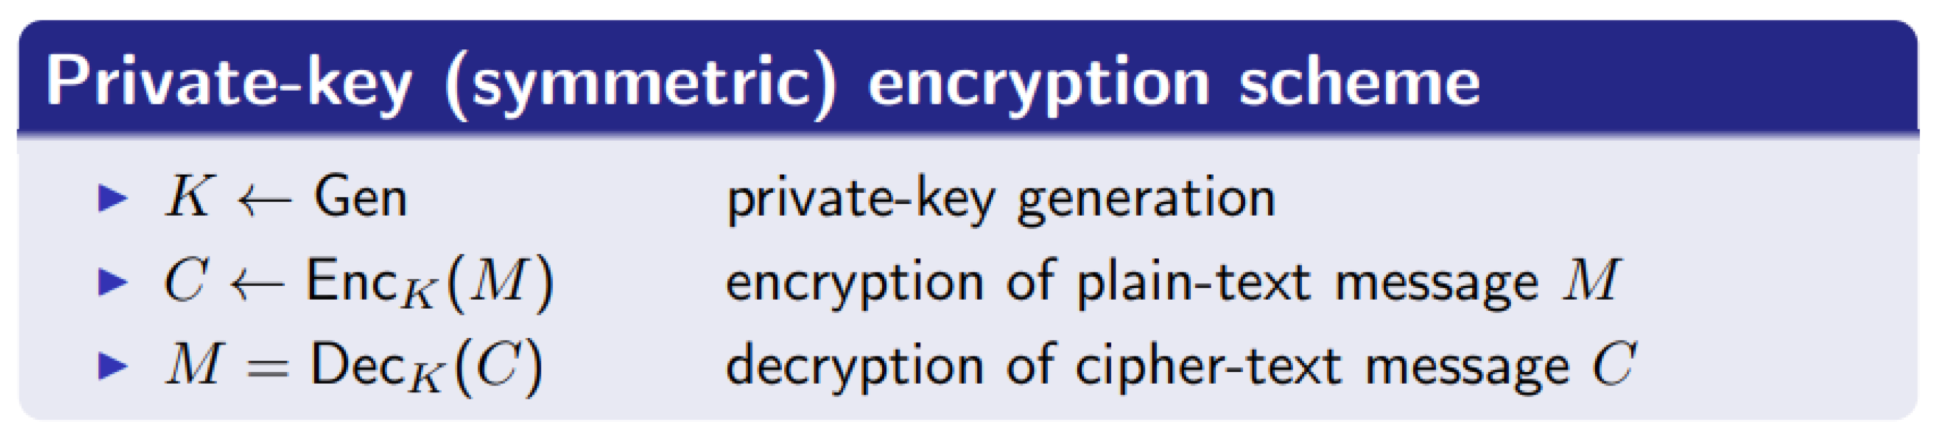

In [3]:
class Cifra(ABC):
    @abstractmethod
    def Gen(self) -> any:
        pass

    def set_key(self, key):
        self.key = key

    @abstractmethod
    def Enc(self, M: str) -> str:
        pass

    @abstractmethod
    def Dec(self, C: str) -> str:
        pass

Por sua vez, o S-AES pode ser abstraído como um conjunto de módulos, que têm como entrada e saída determinada sequência de bits. A classe abstrata Modulo representa esse comportamento. Por sua vez, a classe Estado guarda a formatação matricial em que os bits são manipulados e os bits são organizados na classe Nibble.

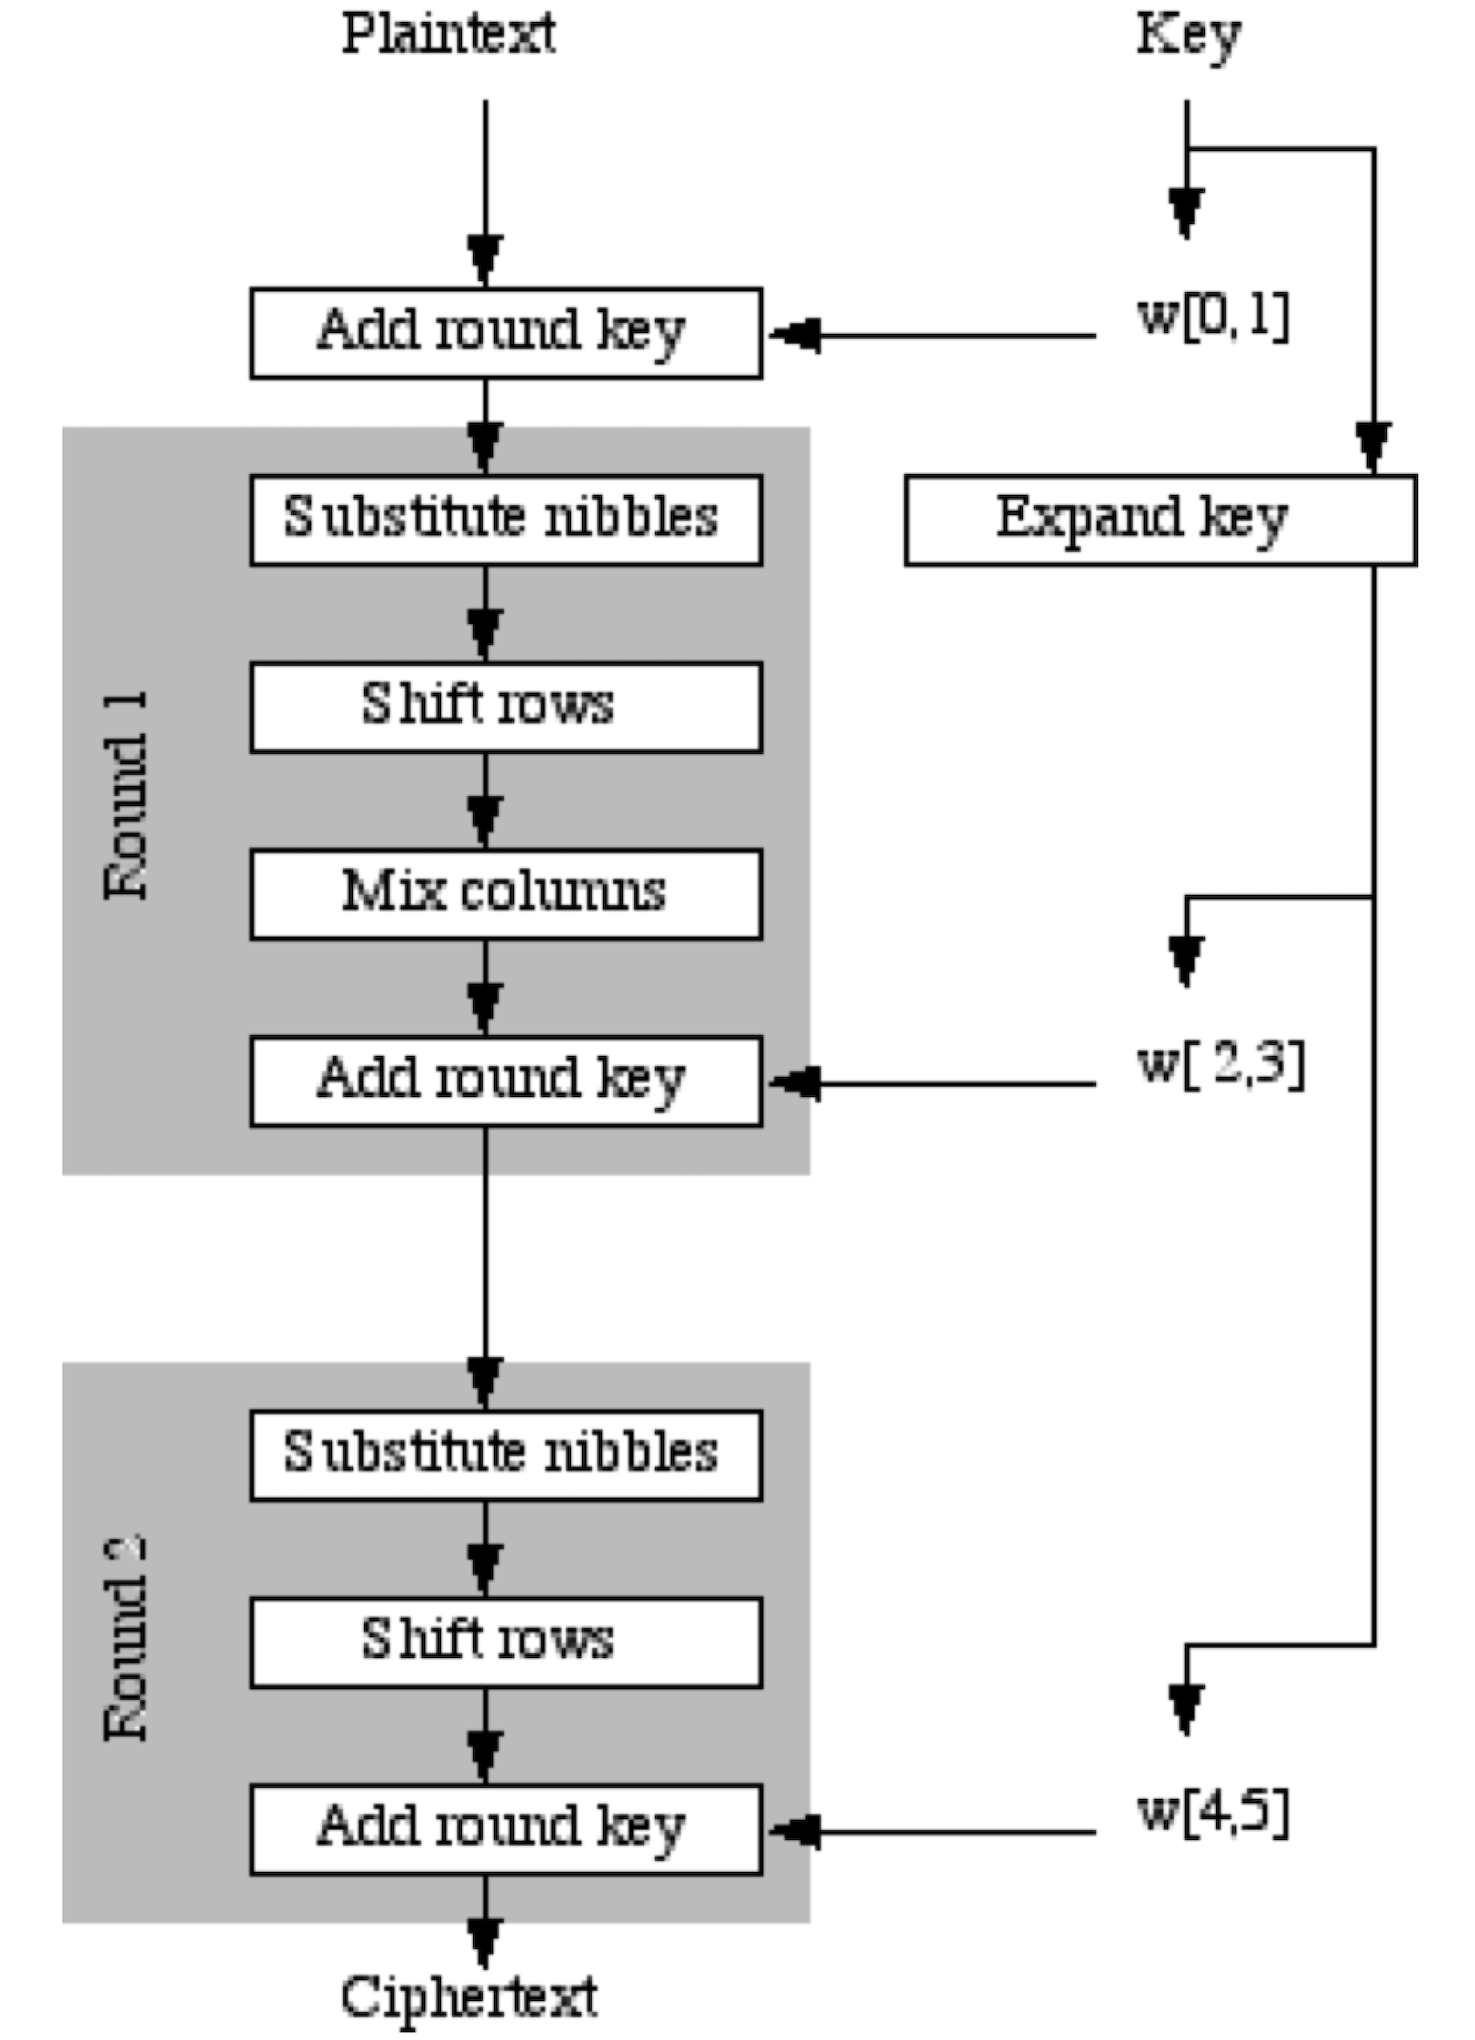

In [4]:
class Nibble:
    def __init__(self,bits):
        self.bits = bits

    def __add__(self,other):
        # Adiciona nibbles por meio de xor
        return Nibble([(other.bits[i]+b)%2 for i,b in enumerate(self.bits)])

    def __str__(self):
        # Formata o nibble em formato de string legível
        return "".join([str(b) for b in self.bits])

    def __eq__(self,other):
        # Verifica se dois nibbles são iguais
        return self.bits == other.bits

    def __len__(self):
        # Retorna o comprimento do nibble
        return len(self.bits)

In [5]:
class Estado:
    def __init__(self, matriz):
        self.matriz = matriz

    def __add__(self, other):
        # Adiciona as matrizes
        resultado = []
        for i in range(len(self.matriz)):
            linha = []
            for j in range(len(self.matriz[0])):
                linha.append((self.matriz[i][j] + other.matriz[i][j]))
            resultado.append(linha)
        return Estado(resultado)

    def __str__(self):
        # Formata o estado em formato de string legível
        resultado = ''
        for l in self.matriz:
            resultado+='|'
            for n in l:
                resultado+=str(n)+'|'
            resultado+='\n'
        return resultado

    def extrair_colunas(self):
        # Muda a organização de linhas do estado para colunas e retorna lista
        colunas = []
        for i in range(len(self.matriz[0])):
            coluna = []
            for j in range(len(self.matriz)):
                coluna.append(self.matriz[j][i])
            colunas.append(coluna)
        return colunas

    def transpor(self):
        # Transpõe a matriz de estado
        return Estado(self.extrair_colunas())

In [6]:
class Modulo(ABC):
    def __init__(self, chave):
        self.key = chave

    @abstractmethod
    def executar(self, T : Estado) -> Estado:
        pass

Todos esses módulos recebem um parâmetro *key*, que determina como a sequência de bits de entrada deve ser tratado.

Como a classe Estado sobrecarrega a operação de adição, o módulo de "Add round key" não precisa ser especializado em uma classe concreta. Por sua vez, a caixa de substituição recebe como chave um dicionário com as substituições e aplica elemento a elemento da matriz.

In [7]:
class CaixaSubstituicao(Modulo):
    def executar(self, T):
        resultado = []
        for i in range(len(T.matriz)):
            linha = []
            for j in range(len(T.matriz[0])):
                linha.append(self.key[tuple((T.matriz[i][j]).bits)])
            resultado.append(linha)
        return Estado(resultado)

A notação matricial representa uma permutação listando diretamente a imagem de cada elemento na ordem.

Seja uma permutação $ \Pi $ do conjunto $P^2$ , com $ P = \{1, 2, \dots, n\} $ e $\pi:P^2→P^2$ bijetora, então:

$$
\Pi = \begin{pmatrix}
1→\pi(1)  & \cdots & n→\pi(n) \\
\vdots & \ddots & \vdots \\
m→\pi(m)  & \cdots & nm→\pi(nm)
\end{pmatrix}
$$

Na notação matricial, escrevemos apenas o segundo elemento, que representa a chave da permutação:

$$
\Pi' = \begin{pmatrix}
\pi(1)  & \cdots & \pi(n) \\
\vdots & \ddots & \vdots \\
\pi(m)  & \cdots & \pi(nm)
\end{pmatrix}
$$

In [8]:
class PermutadorLinhas(Modulo):
    def executar(self, T):
        resultado = []
        for i in range(len(T.matriz)):
            linha = []
            for j in range(len(T.matriz[0])):
                novo_i, novo_j = self.key[i][j]
                linha.append(T.matriz[novo_i][novo_j])
            resultado.append(linha)
        return Estado(resultado)

Antes de prosseguir com a implementação da classe de mistura de colunas, é necessário criar classe auxiliar de polinômios para facilitar cômputo de operações em campos finitos. Na implementação, os coeficientes são armazenados em lista, tais que,

$$[a_0,\dots,a_n] → \Sigma_i^na_ix^i$$

In [9]:
class Polinomio:
    def __init__(self, coeficientes):
        if len(coeficientes) == 0:
            raise ValueError("A lista de coeficientes não pode estar vazia.")
        self.coeficientes = coeficientes

    def __add__(self, other):
        # Adiciona os coeficientes dos polinômios
        coeficientes = [sum(x) for x in itertools.zip_longest(self.coeficientes, other.coeficientes,fillvalue=0)]
        return Polinomio(coeficientes)

    def __sub__(self, other):
        # Subtrai os coeficientes dos polinômios
        other = Polinomio([-x for x in other.coeficientes])
        return self + other

    def __mul__(self, other):
        resultado = Polinomio([0])
        # Multiplica os coeficientes dos polinômios
        for i in range(len(self.coeficientes)):
            resultado+=Polinomio(i*[0]+[self.coeficientes[i]*x for x in other.coeficientes])
        return resultado

    def __str__(self):
        # Formata o polinômio em formato de string legível
        if len(self.coeficientes)==1:
            return str(self.coeficientes[0])
        return  ' + '.join([f'{c if c!=1 else ""}xˆ{len(self.coeficientes)-i-1}' for i,c in enumerate(self.coeficientes[::-1][:-1]) if c!=0 ])+ ((' + ' +str(self.coeficientes[0]))if self.coeficientes[0]!=0 else "")

    def encontrar_maior_grau(self, coeficientes):
        for i in range(len(coeficientes) - 1, -1, -1):
            if coeficientes[i] != 0:
                return i
        return 0

    def __floordiv__(self, other):
        # Calcula o quociente da divisão de dois polinômios
        maior_grau_self = self.encontrar_maior_grau(self.coeficientes)
        maior_grau_other = self.encontrar_maior_grau(other.coeficientes)
        if maior_grau_self < maior_grau_other:
            return Polinomio([0])

        r = self.coeficientes[maior_grau_self]/other.coeficientes[maior_grau_other]
        c = [0]*(maior_grau_self-maior_grau_other)+[r]
        resto = self-Polinomio(c)*other
        return Polinomio(c)+ resto//other

    def __mod__(self,other):
        # Calcula o resto da divisão de dois polinômios
        q = self//other
        return self-q*other

    def __eq__(self, other) -> bool:
        return self.coeficientes == other.coeficientes



O módulo de misturador de colunas possui um parâmetro adicional, que é o polinômio redutor, em determinado campo finito.

In [10]:
class Redutor:
    def __init__(self, redutor, ordem):
        self.redutor = redutor
        self.ordem = ordem

    def reduzir(self, p):
        coef_p_reduzido = [c%2 for c in (p%self.redutor).coeficientes]
        if len(coef_p_reduzido) < self.ordem:
            coef_p_reduzido = coef_p_reduzido+[0]*(self.ordem-len(coef_p_reduzido))
        else:
            coef_p_reduzido = coef_p_reduzido[:self.ordem]
        return Polinomio([int(c) for c in coef_p_reduzido])


Em posse da classe de polinômio e redutor, é possível construir o módulo final de misturados de colunas.

In [11]:
class MisturadorColunas(Modulo):
    def set_redutor(self, redutor):
        self.redutor = redutor

    def executar(self, T):
        colunas = T.extrair_colunas()
        resultado = []
        for coluna in colunas:
            parcial = []
            for linha in self.key:
                soma = Polinomio([0])
                for i, elemento in enumerate(linha):
                    # É necessário realizar a inversão de coeficientes, pois a classe de polinômio foi codificada
                    soma += elemento*Polinomio(coluna[i].bits[::-1])
                parcial.append(Nibble((self.redutor.reduzir(soma)).coeficientes[::-1]))
            resultado.append(parcial)
        return Estado((resultado)).transpor()

O último módulo implementado concerne a expansão de chave.
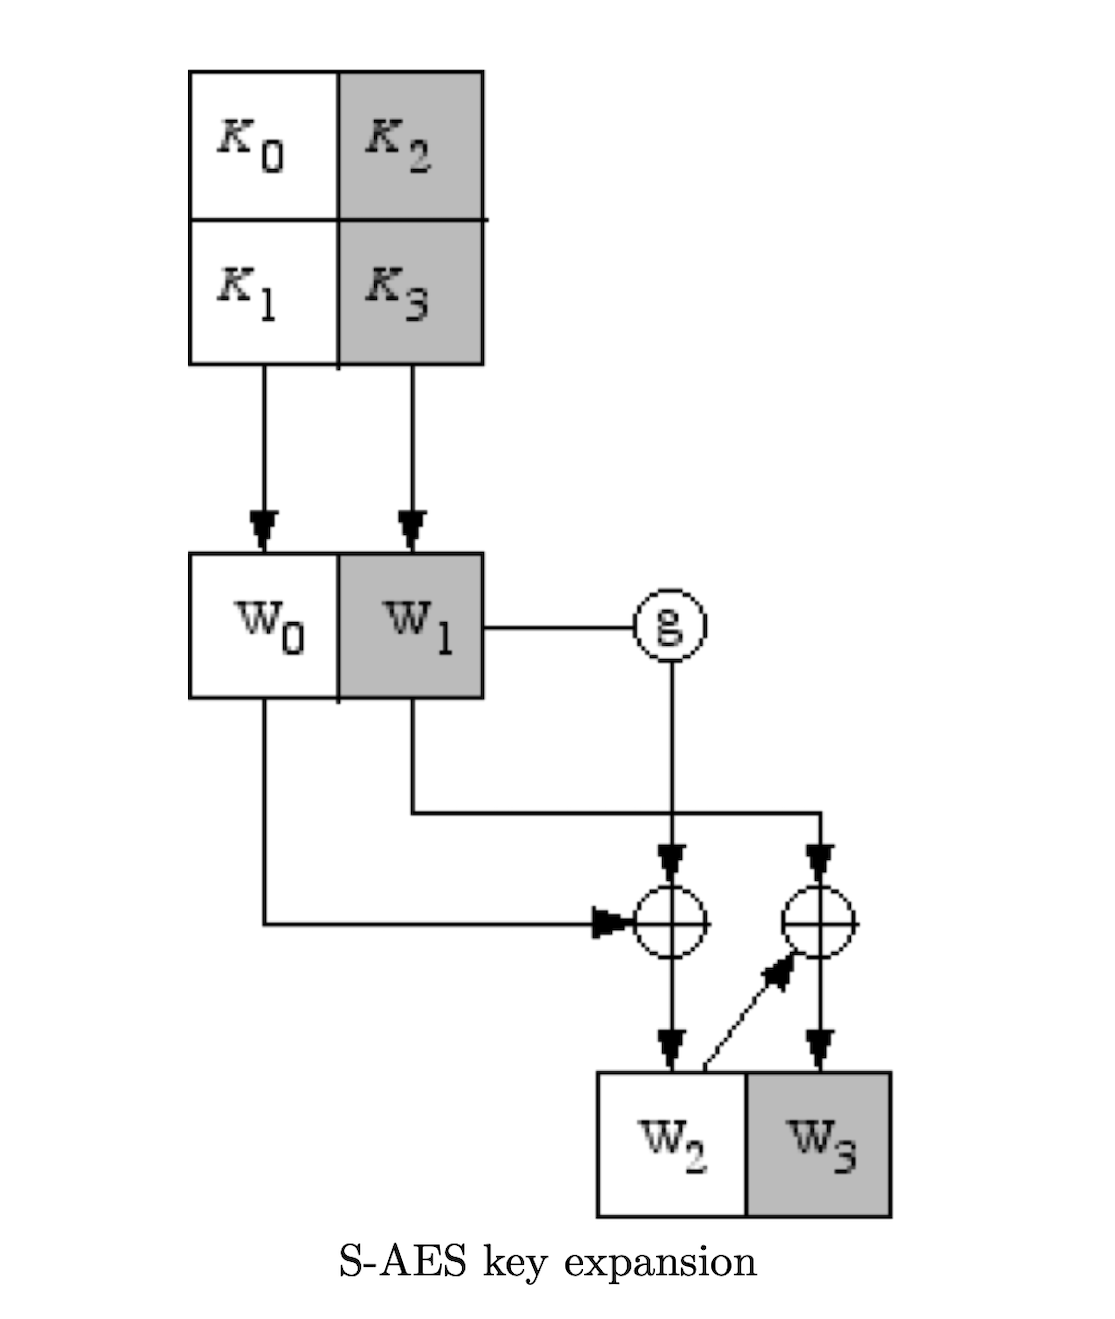

In [12]:
class ExpandirChave(Modulo):
    def __init__(self, key):
        self.key = key
        dicio_substituicao = {
            (0, 0, 0, 0): Nibble([1, 0, 0, 1]),
            (0, 0, 0, 1): Nibble([0, 1, 0, 0]),
            (0, 0, 1, 0): Nibble([1, 0, 1, 0]),
            (0, 0, 1, 1): Nibble([1, 0, 1, 1]),
            (0, 1, 0, 0): Nibble([1, 1, 0, 1]),
            (0, 1, 0, 1): Nibble([0, 0, 0, 1]),
            (0, 1, 1, 0): Nibble([1, 0, 0, 0]),
            (0, 1, 1, 1): Nibble([0, 1, 0, 1]),

            (1, 0, 0, 0): Nibble([0, 1, 1, 0]),
            (1, 0, 0, 1): Nibble([0, 0, 1, 0]),
            (1, 0, 1, 0): Nibble([0, 0, 0, 0]),
            (1, 0, 1, 1): Nibble([0, 0, 1, 1]),
            (1, 1, 0, 0): Nibble([1, 1, 0, 0]),
            (1, 1, 0, 1): Nibble([1, 1, 1, 0]),
            (1, 1, 1, 0): Nibble([1, 1, 1, 1]),
            (1, 1, 1, 1): Nibble([0, 1, 1, 1])
        }
        self.caixaSubstituicao = CaixaSubstituicao(dicio_substituicao)
        self.redutor = Redutor(Polinomio([1,1,0,0,1]),4)

    def executar(self, T):
        logger.info(f"\tExecução da {self.key} rodada de expansão de chave")
        logger.info(f"\t\tA chave de origem é {T}")
        words = T.extrair_colunas()
        w0 = Estado([words[0]])
        logger.info(f"\t\tA primeira word é {w0}")
        w1 = Estado([words[1]])
        logger.info(f"\t\tA segunda word é {w1}")
        w1g = self.g(w1.matriz)
        w2 = w0+w1g
        w3 = w1+w2
        return Estado(w2.matriz+w3.matriz).transpor()


    def gerar_constante(self):
        p = Polinomio([0]*(2+self.key)+[1])
        p = self.redutor.reduzir(p)
        return Estado([[Nibble(p.coeficientes[::-1]),Nibble([0,0,0,0])]])

    def g(self, w):
        w = Estado([[w[0][1],w[0][0]]])
        logger.info(f"\t\t\tApós rotação, o resultado intermediário da função g é {w}")
        w = self.caixaSubstituicao.executar(w)
        logger.info(f"\t\t\tApós substituição, o resultado intermediário da função g é {w}")
        c = self.gerar_constante()
        logger.info(f"\t\t\tA constante é {c}")
        resultado = w+c
        logger.info(f"\t\t\tO resultado final da função g é {resultado}")
        return resultado

A classe que implementa a cifra S-AES é dividida na geração das subchaves e encriptação propriamente dita. Em ambos os casos, os módulos são organizados em dicionários.

In [13]:
# prompt: convert ascii string to binary as list of 0s and 1s

def ascii_to_binary_list(ascii_string):
  """Converts an ASCII string to a list of 0s and 1s representing its binary representation.

  Args:
    ascii_string: The input ASCII string.

  Returns:
    A list of integers (0 or 1) representing the binary form of the string.
  """
  binary_list = []
  for char in ascii_string:
    ascii_value = ord(char)
    binary_representation = bin(ascii_value)[2:]  # Convert to binary and remove the '0b' prefix
    # Pad with leading zeros to ensure each character is represented by 8 bits
    padded_binary = binary_representation.zfill(8)
    binary_list.extend([int(bit) for bit in padded_binary])
  return binary_list

In [14]:
class SAES(Cifra):
    def criar_gerador_subchaves(self):
        self.gerador_subchaves = OrderedDict()
        expandir_chave_1 = ExpandirChave(1)
        self.gerador_subchaves['K1'] = expandir_chave_1
        expandir_chave_2 = ExpandirChave(2)
        self.gerador_subchaves['K2'] = expandir_chave_2

    def __init__(self):
        self.criar_gerador_subchaves()
        self.criar_encriptador()

    def set_key(self, key):
        self.key = Estado([[Nibble(key[:4]), Nibble(key[8:12])],
                    [Nibble(key[4:8]), Nibble(key[12:])]])
        self.gerar_subchaves(self.key)

    def criar_encriptador(self):
        self.encriptador = OrderedDict()
        dicio_substituicao = {
            (0, 0, 0, 0): Nibble([1, 0, 0, 1]),
            (0, 0, 0, 1): Nibble([0, 1, 0, 0]),
            (0, 0, 1, 0): Nibble([1, 0, 1, 0]),
            (0, 0, 1, 1): Nibble([1, 0, 1, 1]),
            (0, 1, 0, 0): Nibble([1, 1, 0, 1]),
            (0, 1, 0, 1): Nibble([0, 0, 0, 1]),
            (0, 1, 1, 0): Nibble([1, 0, 0, 0]),
            (0, 1, 1, 1): Nibble([0, 1, 0, 1]),

            (1, 0, 0, 0): Nibble([0, 1, 1, 0]),
            (1, 0, 0, 1): Nibble([0, 0, 1, 0]),
            (1, 0, 1, 0): Nibble([0, 0, 0, 0]),
            (1, 0, 1, 1): Nibble([0, 0, 1, 1]),
            (1, 1, 0, 0): Nibble([1, 1, 0, 0]),
            (1, 1, 0, 1): Nibble([1, 1, 1, 0]),
            (1, 1, 1, 0): Nibble([1, 1, 1, 1]),
            (1, 1, 1, 1): Nibble([0, 1, 1, 1])
        }
        caixa_substituicao = CaixaSubstituicao(dicio_substituicao)
        self.encriptador['SB'] = caixa_substituicao
        permutador_linhas = PermutadorLinhas([[[0,0], [0,1]],
                                              [[1,1], [1, 0]]])
        self.encriptador['PL'] = permutador_linhas
        misturador_colunas = MisturadorColunas([[Polinomio([1]), Polinomio([0,0,1])],
                                                [Polinomio([0,0,1]), Polinomio([1])]])
        misturador_colunas.set_redutor(Redutor(Polinomio([1,1,0,0,1]),4))
        self.encriptador['MC'] = misturador_colunas

    def Gen(self) -> str:
        raise NotImplementedError()

    def gerar_subchaves(self, K) -> OrderedDict:
        logger.info(f'Gerando subchaves a partir da chave {K}')
        self.subchaves = OrderedDict()
        T = self.gerador_subchaves['K1'].executar(K)
        logger.info(f'\tApós a realização da operação K1, a sequência resultante é {T}')
        self.subchaves['K1'] = T
        T = self.gerador_subchaves['K2'].executar(T)
        logger.info(f'\tApós a realização da operação K2, a sequência resultante é {T}')
        self.subchaves['K2'] = T
        logger.info(f'As subchaves são "K1" {saes.subchaves["K1"]} e "K2" {saes.subchaves["K2"]}')

    def formatar_hexadecimal(self, C):
        return hex(int("".join(str(int(bit)) for bit in C), 2))

    def formatar_base64(self, C):
        C = "".join(str(int(bit)) for bit in C)
        C = int(C, 2).to_bytes(len(C) // 8, byteorder='big')
        return base64.b64encode(C).decode('ascii')

    def Enc(self, M: str):
        logger.info(f'Encriptando a mensagem {M}')
        T = ascii_to_binary_list(M)
        T = [[Nibble(T[:4]), Nibble(T[8:12])],
             [Nibble(T[4:8]), Nibble(T[12:])]]
        T = Estado(T)
        logger.info(f'\tApós a realização da conversão para binário e formatação em Estado, a sequência resultante é {T}')
        T = T + self.key
        logger.info(f'\tApós a realização da operação de adição com a primeira subchave, a sequência resultante é {T}')
        T = self.encriptador['SB'].executar(T)
        logger.info(f'\tApós a realização da operação SB, a sequência resultante é {T}')
        T = self.encriptador['PL'].executar(T)
        logger.info(f'\tApós a realização da operação PL, a sequência resultante é {T}')
        T = self.encriptador['MC'].executar(T)
        logger.info(f'\tApós a realização da operação MC, a sequência resultante é {T}')
        T = T + self.subchaves['K1']
        logger.info(f'\tApós a realização da operação de adição com a segunda subchave, a sequência resultante é {T}')
        T = self.encriptador['SB'].executar(T)
        logger.info(f'\tApós a realização da operação SB, a sequência resultante é {T}')
        T = self.encriptador['PL'].executar(T)
        logger.info(f'\tApós a realização da operação PL, a sequência resultante é {T}')
        T = T + self.subchaves['K2']
        logger.info(f'\tApós a realização da operação de adição com a terceira subchave, a sequência resultante é {T}')
        C = T.matriz[0][0].bits+T.matriz[0][1].bits+T.matriz[1][0].bits+T.matriz[1][1].bits
        logger.info(f'A mensagem criptografada é {C}')
        logger.info(f'A mensagem criptografada em hexadecimal é {self.formatar_hexadecimal(C)}')
        logger.info(f'A mensagem criptografada em base64 é {self.formatar_base64(C)}')
        return C

    def Dec(self, C: str) -> str:
        raise NotImplementedError()


In [15]:
logger.info('------------------------------------------')
logger.info('Execução do algoritmo SAES')
saes = SAES()
saes.set_key([1,0,1,0, 0,1,1,1, 0,0,1,1, 1,0,1,1])
M = 'ok'
logger.info('')
C = saes.Enc(M)
logger.info('------------------------------------------')

INFO:root:------------------------------------------
INFO:root:Execução do algoritmo SAES
INFO:root:Gerando subchaves a partir da chave |1010|0011|
|0111|1011|

INFO:root:	Execução da 1 rodada de expansão de chave
INFO:root:		A chave de origem é |1010|0011|
|0111|1011|

INFO:root:		A primeira word é |1010|0111|

INFO:root:		A segunda word é |0011|1011|

INFO:root:			Após rotação, o resultado intermediário da função g é |1011|0011|

INFO:root:			Após substituição, o resultado intermediário da função g é |0011|1011|

INFO:root:			A constante é |1000|0000|

INFO:root:			O resultado final da função g é |1011|1011|

INFO:root:	Após a realização da operação K1, a sequência resultante é |0001|0010|
|1100|0111|

INFO:root:	Execução da 2 rodada de expansão de chave
INFO:root:		A chave de origem é |0001|0010|
|1100|0111|

INFO:root:		A primeira word é |0001|1100|

INFO:root:		A segunda word é |0010|0111|

INFO:root:			Após rotação, o resultado intermediário da função g é |0111|0010|

INFO:root:	

In [16]:
print(f'As subchaves são "K1" {saes.subchaves["K1"]} e "K2" {saes.subchaves["K2"]}')

As subchaves são "K1" |0001|0010|
|1100|0111|
 e "K2" |0111|0101|
|0110|0001|



In [17]:
print(f'A mensagem criptografada é {C}')

A mensagem criptografada é [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]


## Comparação com AES

A didaticidade do S-AES é constatada na comparação com o AES. O tamanho do bloco, tamanho da chave, número de rodadas de encriptação e de expansão da chave são reduzidos, bem como o expoente do campo finito, porém todos esses elementos ainda que simplificados estão presentes no algoritmo, conforme pode ser constatado no esquema do AES abaixo.

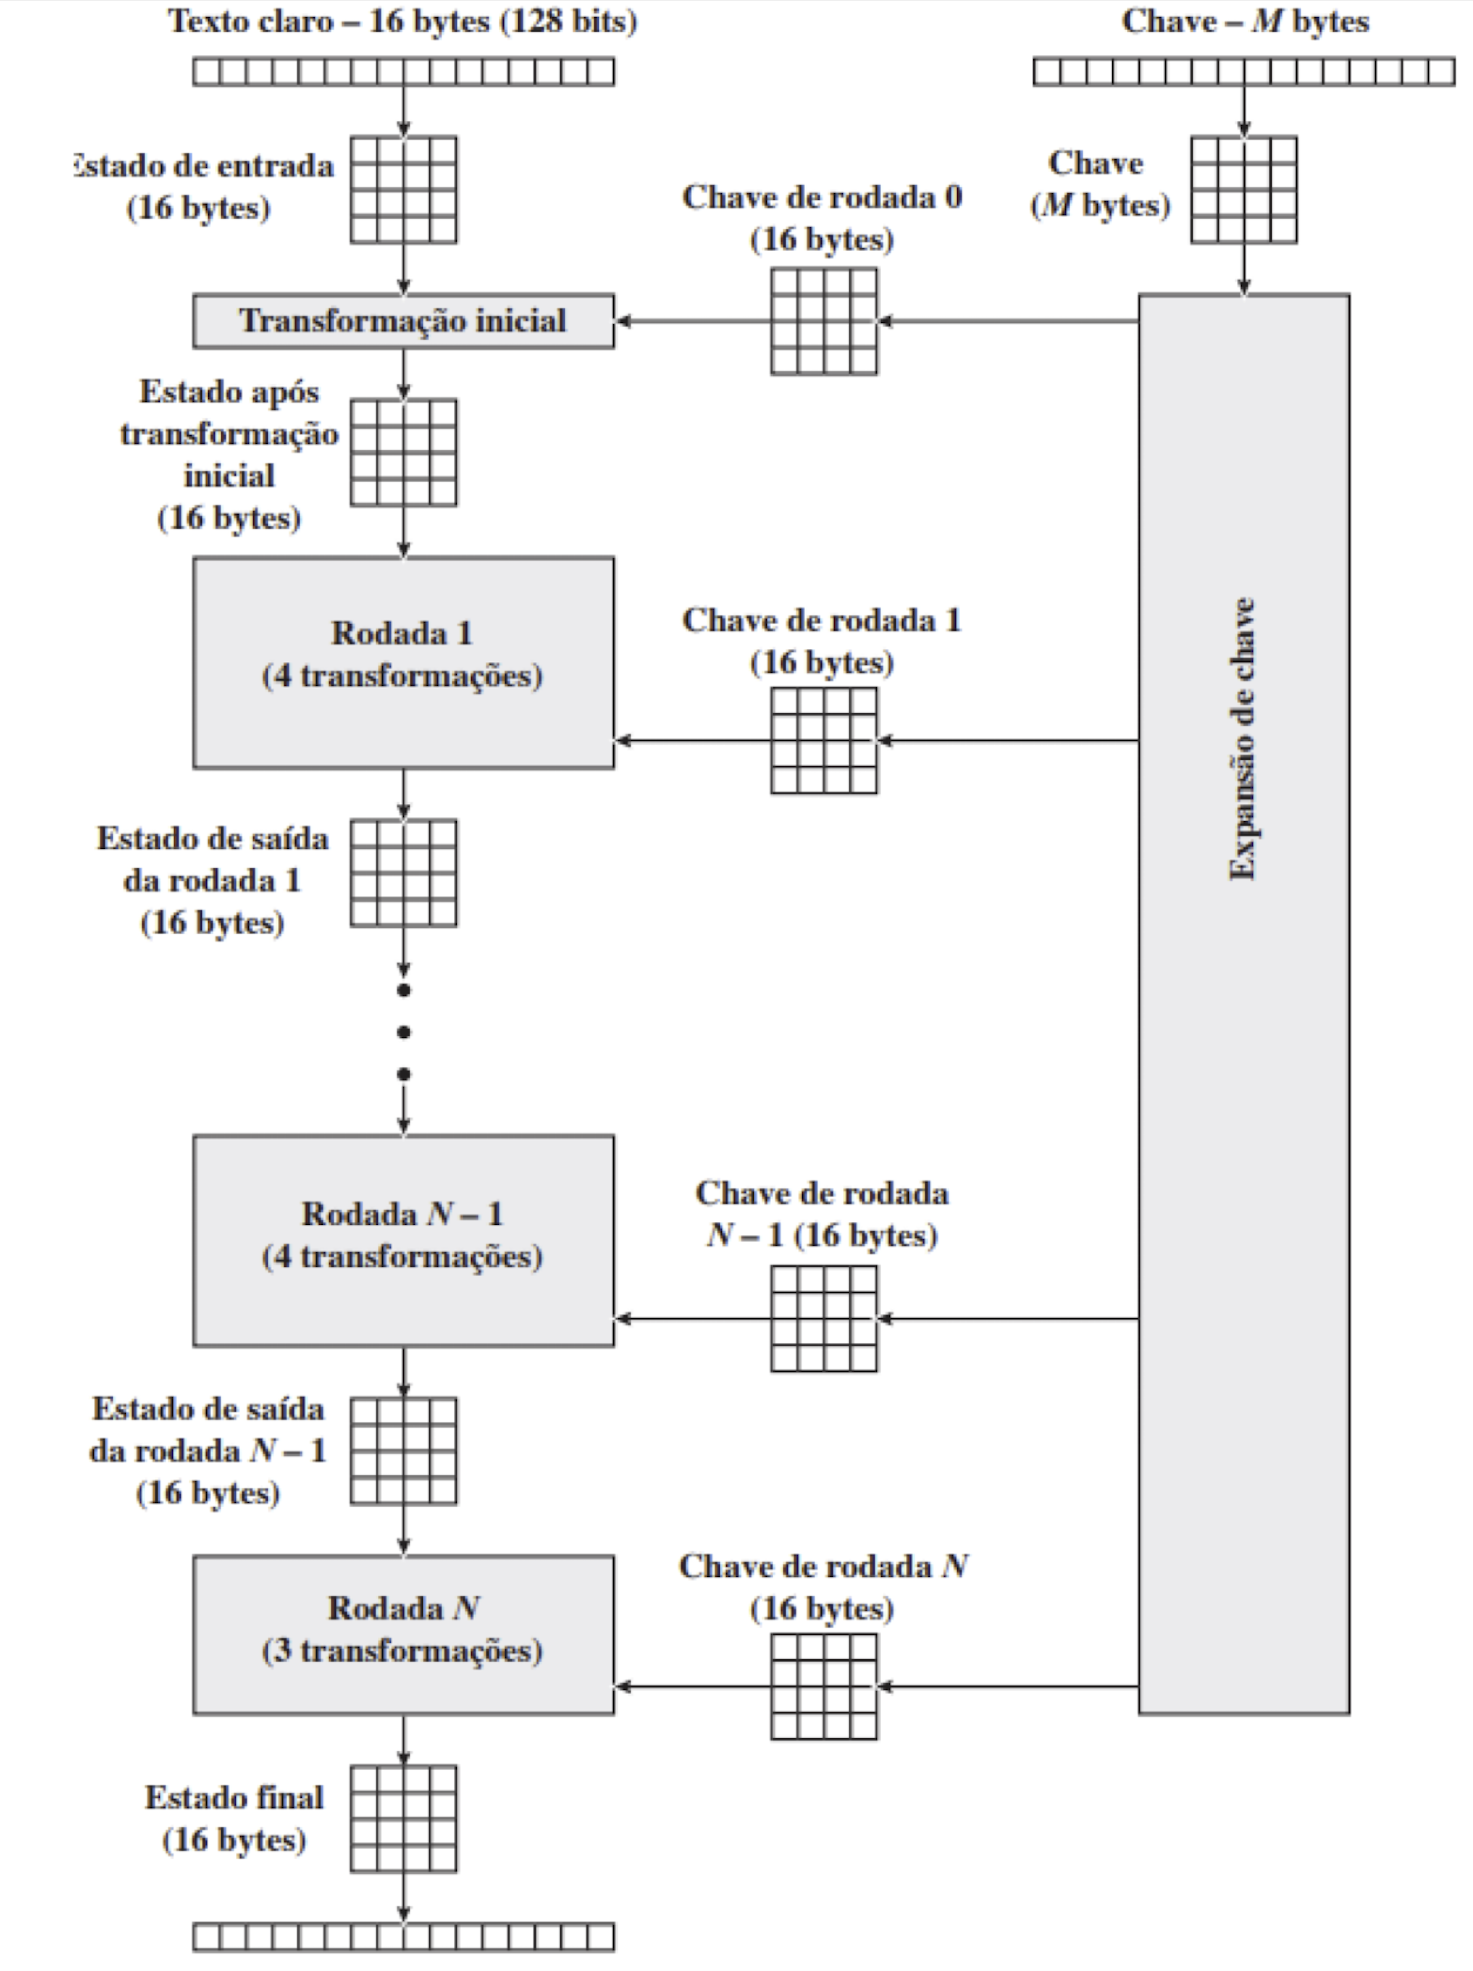

Se se detalhar a nível dos módulos individuais, as mesmas operações de caixa de substituição, permutação de linhas e mistura de colunas estão presentes, tanto nas rodadas do AES quanto do S-AES. O mesmo ocorre para as etapas de expansão da chave. Adaptando-se o código dos módulos para comportar essas expansões, seria possível construir o algoritmo do AES com o mesmo arcabouço do S-AES.

# Parte II

Aproveita-se o mesmo arcabouço do trabalho anterior.

A cifra de bloco estabelece como realizar a (des)criptografia de um único bloco, mas não como realizar a (des)criptografia de uma sequência de bits com comprimento superior ao tamanho de bloco. O modo de operação define como isso deve ser feito. Começa-se com a definição de uma classe abstrata, que define um modo de operação genérico. É necessário que haja funcionalidades de encriptação e decriptação, além de estabelecimento da cifra em si.

In [18]:
class ModoOperacao(ABC):
    @abstractmethod
    def encriptar(self, M: str) -> str:
        pass

    @abstractmethod
    def decriptar(self, C: str) -> str:
        pass

    def __init__(self, cifra: Cifra):
        self.cifra = cifra

O modo de operação ECB (Electronic Codebook) consiste na simples separação da mensagem em blocos do tamanho exato de entrada para a cifra e encriptação ou decriptação deles, com eventual *padding* para completar bloco final, caso o comprimento da mensagem não seja divisível pelo tamanho do bloco. Pode apresentar fragilidade se a mensagem for suficientemente grande, pois, como não há variabilidade de transformação dos blocos, blocos semelhantes de entrada resultam em blocos semelhantes de saída.

In [19]:
class ECB(ModoOperacao):
    def set_tamanho_bloco(self, tamanho_bloco):
        self.tamanho_bloco = tamanho_bloco

    def encriptar(self, M: str) -> str:
        logger.info(f'Encriptando mensagem {M}')
        # Inicializando a mensagem criptografada
        C = []
        C_64 = ""
        # Para cada bloco da mensagem
        for i in range(0, len(M), self.tamanho_bloco):
            logger.info(f'Encriptando bloco {M[i:i+self.tamanho_bloco]}')
            C_atual = self.cifra.Enc(M[i:i+self.tamanho_bloco])
            C_atual64 = self.cifra.formatar_base64(C_atual)
            logger.info(f'Após a realização da encriptação, o bloco resultante é {C_atual}')
            logger.info(f'Após a realização da encriptação, o bloco resultante em base64 é {C_atual64}')
            # Concatena bloco atual com mensagem criptografada
            C += C_atual
            C_64 += C_atual64
            logger.info('----------------------------------------------')
        logger.info(f'A mensagem criptografada é: {C}')
        logger.info(f'A mensagem criptografada em base64 é: {self.cifra.formatar_base64(C)}')
        return C

    def decriptar(self, C: str) -> str:
        raise NotImplementedError()

A aplicação do modo de operação e apresentação da fragilidade serão desmonstradas com um trecho da música Around the world de Daft Punk, cujo clipe pode ser acessado em https://www.youtube.com/watch?v=K0HSD_i2DvA. Para além da qualidade e relevância da música para o genêro eletrônico, a música foi escolhida por conter aproximadamente 144 repetições do verso "around the world".

In [20]:
def encrypt_saes_ecb(texto, chave):
    logger.info('------------------------------------------')
    logger.info('Execução do modo de operação EBC com algoritmo SAES')
    saes = SAES()
    saes.set_key(chave)
    logger.info('')
    ecb = ECB(saes)
    ecb.set_tamanho_bloco(2)
    M = 'Around the world, around the world'
    C = ecb.encriptar(texto)
    logger.info('------------------------------------------')
    return C

In [21]:
C = encrypt_saes_ecb('Around the world, around the world', [1,0,1,0, 0,1,1,1, 0,0,1,1, 1,0,1,1])

INFO:root:------------------------------------------
INFO:root:Execução do modo de operação EBC com algoritmo SAES
INFO:root:Gerando subchaves a partir da chave |1010|0011|
|0111|1011|

INFO:root:	Execução da 1 rodada de expansão de chave
INFO:root:		A chave de origem é |1010|0011|
|0111|1011|

INFO:root:		A primeira word é |1010|0111|

INFO:root:		A segunda word é |0011|1011|

INFO:root:			Após rotação, o resultado intermediário da função g é |1011|0011|

INFO:root:			Após substituição, o resultado intermediário da função g é |0011|1011|

INFO:root:			A constante é |1000|0000|

INFO:root:			O resultado final da função g é |1011|1011|

INFO:root:	Após a realização da operação K1, a sequência resultante é |0001|0010|
|1100|0111|

INFO:root:	Execução da 2 rodada de expansão de chave
INFO:root:		A chave de origem é |0001|0010|
|1100|0111|

INFO:root:		A primeira word é |0001|1100|

INFO:root:		A segunda word é |0010|0111|

INFO:root:			Após rotação, o resultado intermediário da função g é

In [22]:
print(f'A mensagem criptografada em base64 é {saes.formatar_base64(C)}')

A mensagem criptografada em base64 é 95So+dYuE9ipudPSaPLS/kU8Z5Ko+dYuE9ipudPSaPLS/g==


A fragilidade do modo de operação EBC pode ser constatado ao se observar a repetição do trecho "o+dYuE9ipudPSaPLS/" duas vezes ao longo do texto cifrado em base 64, mesmo para uma sequência não longa de uma string. A repetição pode ser alvo de criptoanálise para a quebra da cifra.

# Parte III

## Instalação e importação de bibliotecas

In [23]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.4 MB/s eta 0:00:00


In [24]:
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad
import numpy as np
from collections import Counter
import random

## Definição de modos de operação e geração de dados para comparação

Para realizar a comparação dos modos de operação, primeiramente se define um valor comum de chave, compartilhado por todos os modos de operação, bem como um valor comum de vetor de inicialização, haja vista que se deseja estabelecer um quadro comum de comparação entre eles. Igualmente, a mesma mensagem deve ser compartilhada, para realizar o controle de variáveis em relação ao critérios de aleatoriedade e tempo de execução. Segue-se com a música de Daft Punk, dessa vez completa, para observar como os algoritmos reagem a blocos repetidos de mensagem.

In [25]:
key = b'1234567890123456'
iv = b'1234567890123456'

In [26]:
M = """Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world
Around the world, around the world"""

In [27]:
modos_operacao = {'ECB':AES.new(key, AES.MODE_ECB),
                  'CBC':AES.new(key, AES.MODE_CBC, iv),
                  'CFB':AES.new(key, AES.MODE_CFB, iv),
                  'OFB':AES.new(key, AES.MODE_OFB, iv),
                  'CTR':AES.new(key, AES.MODE_CTR)}

Para garantir que a mensagem tenha comprimento compatível com o AES, pode ser necessário realizar *padding*.

In [28]:
M_pad = pad(M.encode("ascii", "ignore"), AES.block_size)

Define-se um laço de repetição para mensurar o tempo de encriptação de cada algoritmo. Ao se executarem algumas vezes determinado modo de operação, constatou-se que houve variação, de modo que se faz necessária amostragem para lidar com a própria aleatoriedade do processo, ainda que o algoritmo seja determinístico. Pondera-se se a fonte de aleatoriedade provenha da execução em nuvem do código.

In [29]:
Cs = {}
tempo_criptografia = {'ECB':[],
                      'CBC':[],
                  'CFB':[],
                  'OFB':[],
                  'CTR':[]}

REPETICOES = 10_000
for modo in modos_operacao:
    algo = modos_operacao[modo]
    for r in range(REPETICOES):
        start_time = time.time()
        algo.encrypt(M_pad)
        end_time = time.time()
        tempo_criptografia[modo].append(end_time - start_time)
    Cs[modo] = base64.b64encode(algo.encrypt(M_pad)).decode('ascii')

Para a mensuração de aleatoriedade da mensagem criptografada, utiliza-se como critério a entropia de Shannon. Conceito fundamental na teoria da informação, a métrica da entropia de Shannon busca capturar o grau de "surpresa" de determinado objeto, conforme a probabilidade de se encontrar determinado componente desse objeto. No caso em questão, o objeto é a mensagem e seus componentes são caracteres.

In [30]:
# prompt: measure entropy

def shannon_entropy(text):
  """Calculates the Shannon entropy of a given text.

  Args:
    text: The input string.

  Returns:
    The calculated entropy as a float.
  """
  counts = dict(Counter(text))
  total_count = sum(counts.values())
  entropy = 0.0
  for count in counts.values():
    probability = count / total_count
    entropy -= probability * math.log2(probability)
  return entropy

As mensagens criptografadas em base 64 podem ser observadas abaixo.

In [31]:
entropias = {"original_padding":shannon_entropy(M_pad)}
for m in Cs:
    print(f"A mensagem criptografada com {m} em base64 é {Cs[m]}")
    entropias[m] = shannon_entropy(Cs[m])

A mensagem criptografada com ECB em base64 é tsjNcH4Htdvm814pn1t29azbheYzVnIj9iBjFiTW/kkVK5Zqgl84JtqcHJR9eh1QMp6DoSlnqmqFHJPA8pHttHEuRUkQN9+J5F0AjaHOZDB+n4cHx5ylsDoUOHa5gPZIF+ZPnuIg/T2t+T1bzYI3P0AzJ/QMBBzBPaYPk0uKjdyBopFKUGSC45gDnvdMvTKXFDI+5onj3Eba30bmtrB73Q9e6dxVhvnXpiSlL/5fvVkGpQVNPO+qnOsfwXBbRT8+ZcpkHEfiuLgbIJwkZ1qWOave7SK4oVQ3c66if4r/I2g1zm2lwhmJqoudyAQUgN3TMqCyVRGvEzVXTWOD583zzPC/00TKT7kkS5+0gne7rh9iAG4+/rZIUP/JoFWFrJviGHOjKT+STeorb9jFjwtzLJoXkZ8I2Ui/saJf9ynQsNmaG5lHORbzLrBjp/FCmDHKQpMkukpIVAhw1sBKocGrzp048qQU+b/vR6gBd5pFM/m6yn6LlbsCLQxMomz9GCb5i0+cWMP0Ncwl2I7ZWR9s0mRiA/Vu/sdoAes3LQueP/KDAi8esaYemaOv7PWYSP6wlyAU0wXI+HJyL5GDbZIKV6DrOqzOOASL3wtYm5H8Egl3QJHcq1IEVQnM17Ud0naeWwUZLewkie3sww0gizTdv2WqEwhFvZhhig0c6vLPGCSErtw0bU78eRYqJFq+tNUkdaLTfEGU+ZJRNMBJaaNwrbhGfiVAUe4uRmNe81QKi0m2yM1wfge12+bzXimfW3b1rNuF5jNWciP2IGMWJNb+SRUrlmqCXzgm2pwclH16HVAynoOhKWeqaoUck8Dyke20cS5FSRA334nkXQCNoc5kMH6fhwfHnKWwOhQ4drmA9kgX5k+e4iD9Pa35PVvNgjc/QDMn9AwEHME9pg+TS4qN3IGikUpQZILjmAOe90y9MpcUMj7miePcRtrfRua

O modo de operação ECB repete o mesmo comportamento do bloco II do trabalho. Para qualquer trecho da mensagem criptografada, é possível encontrar ao menos uma repetição ao longo da mensagem. O mesmo não ocorre para os outros modos.

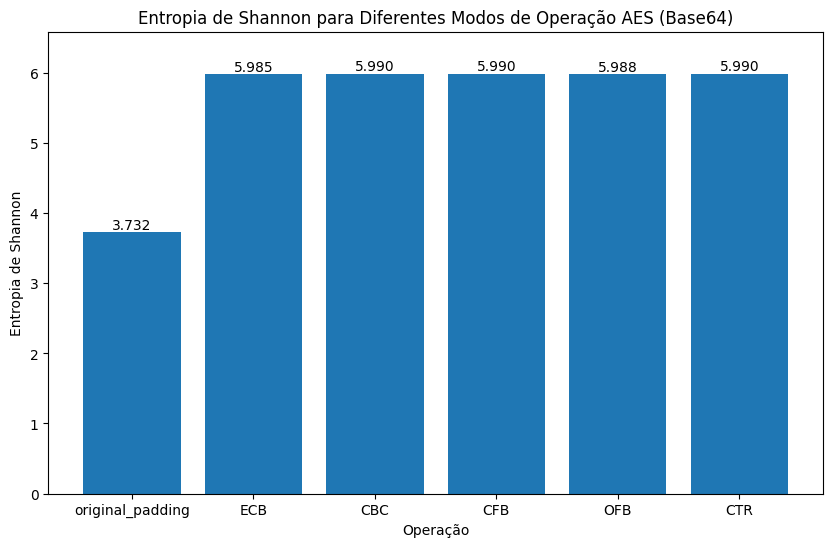

In [32]:
# prompt: bar plot

import matplotlib.pyplot as plt

# Extract data for the bar plot
modes = list(entropias.keys())
entropy_values = list(entropias.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(modes, entropy_values)
plt.xlabel('Operação')
plt.ylabel('Entropia de Shannon')
plt.title('Entropia de Shannon para Diferentes Modos de Operação AES (Base64)')
plt.ylim(0, max(entropy_values) * 1.1) # Set y-axis limits to slightly above max entropy

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

plt.show()

Não se encontrou diferença significativa entre a entropia das mensagens de acordo com o modo de operação empregado. Esperava-se que o ECB fosse significativamente inferior. Possivelmente, a limitação de cálculo de entropia a uma única mensagem tenha sido insuficiente para observar o fenômeno. Realizar o método de amostragem sobre diversas mensagens diferentes pode ser capaz de capturar a fragilidade de aleatoriedade do ECB.

In [33]:
# A entropia máxima ocorre quando a probabilidade de se encontrar um caractere é igual para todos os caracteres
np.sum([-math.log(1/64,2)/64 for c in range(64)])

np.float64(6.0)

De todo modo, todos os modos de operação alcançaram escores elevados de aleatoriedade, superiores à da mensagem original com padding, e chegaram bem próximos à entropia máxima de 6.

In [34]:
# prompt: remove outliers

def remove_outliers_iqr(data, multiplier=1.5):
  """
  Removes outliers from a list of numerical data using the IQR method.

  Args:
    data: A list of numerical data.
    multiplier: The multiplier for the IQR to determine the bounds.

  Returns:
    A list with outliers removed.
  """
  if not data:
    return []

  data_np = np.array(data)
  Q1 = np.percentile(data_np, 25)
  Q3 = np.percentile(data_np, 75)
  IQR = Q3 - Q1

  lower_bound = Q1 - multiplier * IQR
  upper_bound = Q3 + multiplier * IQR

  filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
  return filtered_data

tempo_criptografia_filtered = {}
for modo in tempo_criptografia:
    tempo_criptografia_filtered[modo] = remove_outliers_iqr(tempo_criptografia[modo])


Para prosseguir com a análise de tempo de execução, é necessário retirar outliers que foram observados ao longo da coleta de tempos de execução. Utiliza-se a técnica remoção de outliers que extrapolam em 50% o intervalo interquartílico para mais ou para menos do primeiro e terceiro quartis.

<ipython-input-35-2071897012>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tempo_criptografia_filtered.values(), labels=tempo_criptografia_filtered.keys())


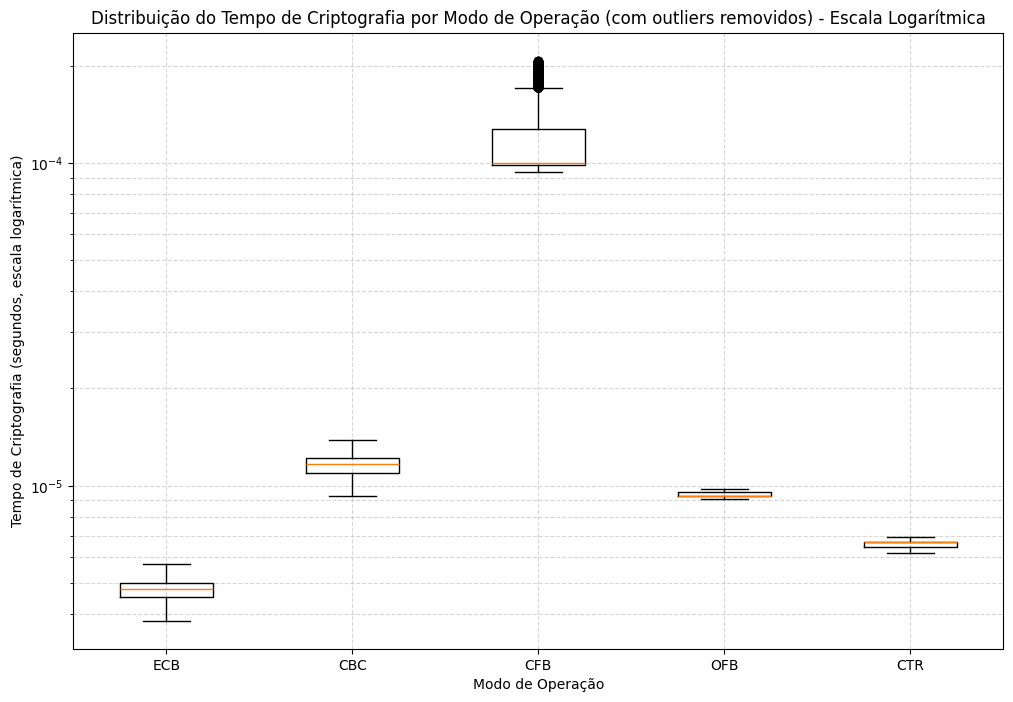

In [35]:
# prompt: box plot log scale

plt.figure(figsize=(12, 8))
plt.boxplot(tempo_criptografia_filtered.values(), labels=tempo_criptografia_filtered.keys())
plt.yscale('log')
plt.xlabel('Modo de Operação')
plt.ylabel('Tempo de Criptografia (segundos, escala logarítmica)')
plt.title('Distribuição do Tempo de Criptografia por Modo de Operação (com outliers removidos) - Escala Logarítmica')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()


Em que pese a fragilidade do ECB, apresentou menor média de tempo de execução, seguido por CTR, CBC, OFB e CFB. O comportamente foi conforme esperado, com maior rapidez de execução do ECB e CTR sobre demais modos.

# Conclusão

Percorrido o caminho do S-AES, perpassando o ECB para chegar ao demais modos de operação ao AES; o segundo trabalho prático expandiu o escopo do primeiro trabalho ao abordar um algoritmo mais complexo, ainda que simplificado, não só em em seus módulos individuais, mas sobretudo pelo refinamento conceitual, a exemplo de operações em campos finitos. Por fim, o bloco III permitiu trabalhar com uma biblioteca contemporânea de criptografia, bem como constatar distintos comportamentos de modos de operação trabalhados em sala de aula.

# Referências

GOOGLE. Gemini via Google Colab [ferramenta de inteligência artificial]. Mountain View, CA: Google, 2024. Disponível em: https://colab.research.google.com/. Acesso em: 21 abr. 2025.

OPENAI. ChatGPT (versão GPT-4) [ferramenta de inteligência artificial]. São Francisco, CA: OpenAI, 2023. Disponível em: https://chat.openai.com/. Acesso em: 21 abr. 2025.